In [51]:
%cd /content/drive/MyDrive/Term2/PRNN/Assignments/Assignment-1

/content/drive/MyDrive/Term2/PRNN/Assignments/Assignment-1


In [52]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import metrics

## Load data and sample them

In [4]:
def load_data(train_file, test_file, delimiter = ','):
 train_data = np.loadtxt(train_file, delimiter=delimiter) 
 test_data = np.loadtxt(test_file, delimiter=delimiter)
 data ={}
 data["train"] = train_data[:,:-1]
 data["train_labels"] = train_data[:,-1]
 data["test"] = test_data[:,:-1]
 data["test_labels"] = test_data[:,-1]
 return data

In [5]:
def get_class_samples(data, n_samples, plot =False):
  class2_indices = np.where(data["train_labels"] == -1)[0]
  class1_indices = np.where(data["train_labels"] == 1)[0]

  n_class2 = class2_indices.shape[0]
  n_class1 = class1_indices.shape[0]

  #Select random indices for n_samples
  class2_select_indices = class2_indices [np.random.choice(n_class2, n_samples, replace = False)]
  class1_select_indices = class1_indices[np.random.choice(n_class1, n_samples, replace = False)]

  class2_samples = data["train"] [class2_select_indices]
  class1_samples = data["train"] [class1_select_indices]

  train_samples = {}
  train_samples["class1"] = class1_samples
  train_samples["class2"] = class2_samples

  if plot:
    plt.figure()
    plt.scatter(class1_samples[:,0], class1_samples[:,1], marker = '+', c = 'r', label = 'Class1')
    plt.scatter(class2_samples[:,0], class2_samples[:,1], label = 'Class2')
    plt.title(f'Samples per class = {n_samples}')
    plt.legend(loc="best")
    plt.show()

  knn_data = {}
  knn_data["X"] = np.append(train_samples["class1"], train_samples["class2"], axis = 0)
  knn_data["y"] = np.append(data["train_labels"][class1_select_indices], data["train_labels"][class2_select_indices], axis = 0)

  sampled_data = {}
  sampled_data["knn"] = knn_data
  sampled_data["bayes"] = train_samples
  return sampled_data

## Bayes Classifier code

In [6]:
def estimate_params(train_samples):
  class1_samples = train_samples["class1"]
  class2_samples = train_samples["class2"]

  class1_param = {}
  class2_param = {}
  class1_param["mean"] = np.mean(class1_samples, axis= 0)
  class2_param["mean"] = np.mean(class2_samples, axis= 0)
  class1_param["cov"] = np.cov(class1_samples, rowvar=False)
  class2_param["cov"] = np.cov(class2_samples, rowvar=False)

  params ={}
  params["class1"] = class1_param
  params["class2"] = class2_param

  return params


In [7]:
def f_gaussian(params):
  c1_mean = params["class1"]["mean"]
  c1_cov = params["class1"]["cov"]
  c2_mean = params["class2"]["mean"]
  c2_cov = params["class2"]["cov"]

  d = c1_mean.shape[0]
  if d==1:
    mu1 = c1_mean
    var1 = c1_cov
    f1 = lambda x: 1/np.sqrt(2 * np.pi * var1) * np.exp(-((x - mu1)**2)/var1)

    mu2 = c2_mean
    var2 = c2_cov
    f2 = lambda x: 1/np.sqrt(2 * np.pi * var2) * np.exp(-((x - mu2)**2)/var2)

  else:
    k1 = 1/ (((2 * np.pi) ** (d/2)) *(np.linalg.det(c1_cov) ** 0.5))
    f1 = lambda x: k1 * np.exp(-np.matmul(x - c1_mean, np.matmul(np.linalg.pinv(c1_cov), x - c1_mean)))

    k2 = 1/ (((2 * np.pi) ** (d/2)) *(np.linalg.det(c2_cov) ** 0.5))
    f2 = lambda x: k2 * np.exp(-np.matmul(x - c2_mean, np.matmul(np.linalg.pinv(c2_cov), x - c2_mean)))

  return [f1, f2]


def f_gaussc1_expc2(params):
  c1_mean = params["class1"]["mean"]
  c1_cov = params["class1"]["cov"]
  c2_mean = params["class2"]["mean"]
  exp_param_x1 = 1/c2_mean[0]
  exp_param_x2 = 1/c2_mean[1]

  d = c1_mean.shape[0]
  k1 = 1/ (((2 * np.pi) ** (d/2)) *(np.linalg.det(c1_cov) ** 0.5))
  f1 = lambda x: k1 * np.exp(-np.matmul(x - c1_mean, np.matmul(np.linalg.inv(c1_cov), x - c1_mean)))

  f2 = lambda x: exp_param_x1 * np.exp(-exp_param_x1 * x[0]) * exp_param_x2 * np.exp(-exp_param_x2 * x[1])
  return [f1, f2]


In [8]:
def bayes_classifier(params, test_data, class1_density = 'gaussian', class2_density = 'gaussian'):
  if class2_density == 'exponential':
    f1, f2 = f_gaussc1_expc2(params)
  else:
    f1, f2 = f_gaussian(params)
  pred = []

  for test in test_data["test"]:
    if(f1(test)>f2(test)):
      pred.append(1)
    else:
      pred.append(-1)

  conf_matrix = metrics.confusion_matrix(test_data["test_labels"], pred, normalize='true')
  score = {}
  score["total_acc"] = metrics.accuracy_score(test_data["test_labels"], pred)
  score["class1_acc"] = conf_matrix[0,0]
  score["class2_acc"] = conf_matrix[1,1]

  return score

## kNN

In [9]:
def kNN(train_data, test_data, metric='mahalanobis', K =[1, 2, 3, 4, 5, 10]):
  scores_list = []
  for k in K:
      score  = {}
      if metric == 'mahalanobis':
        classifier = KNeighborsClassifier(n_neighbors=k, metric='mahalanobis', \
                                          metric_params={'V': np.cov(train_data["X"], rowvar=False)})
      elif metric == 'euclidean':
        classifier = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
      classifier.fit(train_data["X"], train_data["y"])
      y_pred = classifier.predict(test_data["test"])
      y_test = test_data["test_labels"]
      conf_matrix = metrics.confusion_matrix(y_test, y_pred, normalize='true')

      score["k"]=k
      score["total_acc"] = metrics.accuracy_score(y_test,y_pred)
      score["class1_acc"] = conf_matrix[0,0]
      score["class2_acc"] = conf_matrix[1,1]
      scores_list.append(score)

  return scores_list

**Plot gaussian densities**

In [10]:
def plot_gaussian_density(data_bayes, params, title, colors = ['navy', 'darkorange']):
  splot = plt.subplot(2, 1, 1 )
  plt.scatter(data_bayes["class1"][:,0], data_bayes["class1"][:,1], marker = '+', c = colors[0], label = 'Class1')
  plt.scatter(data_bayes["class2"][:,0], data_bayes["class2"][:,1], marker = '+', c= colors[1],label = 'Class2')
  plt.title(title)
  plt.legend(loc="best")
  #plt.show()
  c1_mean = params["class1"]["mean"]
  c1_cov = params["class1"]["cov"]
  v, w = np.linalg.eigh(c1_cov)
  v = 2. * np.sqrt(2.) * np.sqrt(v)
  u = w[0] / np.linalg.norm(w[0])
          # Plot an ellipse to show the Gaussian component
  angle = np.arctan(u[1] / u[0])
  angle = 180. * angle / np.pi  # convert to degrees
  ell = mpl.patches.Ellipse(c1_mean, v[0], v[1], 180. + angle, color=colors[0])
  ell.set_clip_box(splot.bbox)
  ell.set_alpha(0.5)
  splot.add_artist(ell)

  c2_mean = params["class2"]["mean"]
  c2_cov = params["class2"]["cov"]
  v, w = np.linalg.eigh(c2_cov)
  v = 2. * np.sqrt(2.) * np.sqrt(v)
  u = w[0] / np.linalg.norm(w[0])
  # Plot an ellipse to show the Gaussian component
  angle = np.arctan(u[1] / u[0])
  angle = 180. * angle / np.pi  # convert to degrees
  ell = mpl.patches.Ellipse(c2_mean, v[0], v[1], 180. + angle, color=colors[1])
  ell.set_clip_box(splot.bbox)
  ell.set_alpha(0.5)
  splot.add_artist(ell)

  plt.rcParams['figure.figsize'] = [10, 10]
  plt.axis('scaled')
  plt.xlim(-3., 7.)
  plt.ylim(-3., 7.)
  plt.xticks(())
  plt.yticks(())
  plt.xscale('linear')
  plt.yscale('linear')
  plt.show()

## EM algorithm

In [11]:
def gmm_bayes(train_data, test_data):
  gm = GaussianMixture(n_components=2, random_state=0, init_params = 'random').fit(train_data)
  #em_params = gm.get_params()
  em_params = {}
  em_params["class1"]={}
  em_params["class2"]={}
  em_params["class1"]["mean"] = gm.means_[0]
  em_params["class1"]["cov"] = gm.covariances_[0]
  em_params["class2"]["mean"] = gm.means_[1]
  em_params["class2"]["cov"] = gm.covariances_[1]


  print("GMM Estimated Params: \n", em_params)

  #Evaluate on test data
  pred = gm.predict(test_data["test"])
  pred[np.where(pred==0)] = -1
  conf_matrix = metrics.confusion_matrix(test_data["test_labels"], pred, normalize='true')
  em_score = {}
  em_score["total_acc"] = metrics.accuracy_score(test_data["test_labels"], pred)
  em_score["class1_acc"] = conf_matrix[0,0]
  em_score["class2_acc"] = conf_matrix[1,1]

  print('\n\nAccuracy metrics for mixture density estimation(kmeans init): ')
  print(em_score)
  return em_params

In [12]:
def evaluate_bayes_knn_em(data, n_samples):
  print(f"\n\n NO. OF SAMPLES = {n_samples}")
  sampled_data = get_class_samples(data, n_samples, plot=False)
  data_bayes = sampled_data["bayes"]
  data_knn = sampled_data["knn"]
  params = estimate_params(data_bayes)

  print("\nEstimated parameters for Gaussian: \n", params)
  score = bayes_classifier(params, data)
  plot_gaussian_density(data_bayes, params, f'ML estimate (N = {n_samples})')
  print("\nAccuracy metrics of Bayes Classifier: ", score)
  print("\n-----------------------------------------------------------------------------------------------------------------------------------------")

  knn_scores = kNN(data_knn, data, K = [1, 3, 5])
  print("\nAccuracy metrics of kNN :")
  print(knn_scores)
  print("\n-----------------------------------------------------------------------------------------------------------------------------------------")
  
  gmm_params = gmm_bayes(sampled_data["knn"]["X"], data)
  plot_gaussian_density(data_bayes, gmm_params, f'EM estimate (N = {n_samples})')

#Problem 1.1

## Dataset (a)

### Bayes Classifier vs NN Classifier

In [13]:
p1a_data = load_data('./P1a_train_data_2D.txt', './P1a_test_data_2D.txt')

##### Plot true density

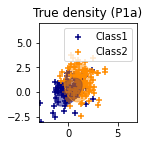

In [15]:
sampled_data = get_class_samples(p1a_data, 100, plot=False)
data_bayes = sampled_data["bayes"]
true_param = {}
true_param["class1"]={}
true_param["class2"]={}
true_param["class1"]["mean"] = np.array([0,0])
true_param["class1"]["cov"] = np.array([[1,0.5],[0.5,1]])
true_param["class2"]["mean"] = np.array([1,1])
true_param["class2"]["cov"] = np.array([[1,0],[0,2]])
plot_gaussian_density(data_bayes, true_param, 'True density (P1a)')

##### Sample data, estimate density and implement Bayes Classifier and NN classifier

In [ ]:
for n_samples in [5, 10 , 25, 75, 100]:
  print(f"\n\n NO. OF SAMPLES = {n_samples}")
  sampled_data = get_class_samples(p1a_data, n_samples, plot=False)
  data_bayes = sampled_data["bayes"]
  data_knn = sampled_data["knn"]
  params = estimate_params(data_bayes)

  print("\nEstimated parameters for Gaussian: \n", params)
  score = bayes_classifier(params, p1a_data)
  print("\nAccuracy metrics of Bayes Classifier: ", score)
  print("\n-----------------------------------------------------------------------------------------------------------------------------------------")

  knn_scores = kNN(data_knn, p1a_data, K = [1, 3, 5])
  print("\nAccuracy metrics of kNN :")
  print(knn_scores)
  print("\n-----------------------------------------------------------------------------------------------------------------------------------------")
  
  plot_gaussian_density(data_bayes, params, f'ML estimate (N = {n_samples})')
  gmm_bayes(sampled_data["knn"]["X"])


In [ ]:
evaluate_bayes_knn_em(p1a_data,5)

In [ ]:
evaluate_bayes_knn_em(p1a_data,10)

In [ ]:
evaluate_bayes_knn_em(p1a_data,25)

In [ ]:
evaluate_bayes_knn_em(p1a_data,75)

In [ ]:
evaluate_bayes_knn_em(p1a_data,100)

### P2b. EM Algorithm vs Bayes 

In [ ]:
p1b_data = load_data('./P1b_train_data_2D.txt', './P1b_test_data_2D.txt')

In [ ]:
evaluate_bayes_knn_em(p1b_data,5)

In [ ]:
evaluate_bayes_knn_em(p1b_data,10)

In [ ]:
evaluate_bayes_knn_em(p1b_data,25)

In [ ]:
evaluate_bayes_knn_em(p1b_data,50)

In [ ]:
evaluate_bayes_knn_em(p1b_data,75)

In [ ]:
evaluate_bayes_knn_em(p1b_data,100)

In [ ]:
evaluate_bayes_knn_em(p1b_data,100)

### Mixture Density estimation using EM algorithm

#### Use k-means for initialization

In [ ]:
gm = GaussianMixture(n_components=2, random_state=0).fit(p1b_data["train"])
em_params = gm.get_params()
means = gm.means_
cov = gm.covariances_
print("Estimated Means: \n", means)
print("\n\nEstimated covariance matrices: \n", cov)

#Evaluate on test data
pred = gm.predict(p1b_data["test"])
pred[np.where(pred==0)] = -1
conf_matrix = metrics.confusion_matrix(p1b_data["test_labels"], pred, normalize='true')
em_score = {}
em_score["total_acc"] = metrics.accuracy_score(p1b_data["test_labels"], pred)
em_score["class1_acc"] = conf_matrix[0,0]
em_score["class2_acc"] = conf_matrix[1,1]

print('\n\nAccuracy metrics for mixture density estimation(kmeans init): ')
print(em_score)

In [ ]:
plot_results(p1b_data["test"], gm.predict(p1b_data["test"]), gm.means_, gm.covariances_, 0,
             'Gaussian Mixture')

#### Random initialization

In [ ]:
gm_randominit = GaussianMixture(n_components=2, random_state=0, init_params = 'random').fit(p1b_data["train"])
em_params = gm_randominit.get_params()
means = gm_randominit.means_
cov = gm_randominit.covariances_
print("Estimated Means: \n", means)
print("\n\nEstimated covariance matrices: \n", cov)

#Evaluate on test data
pred = gm_randominit.predict(p1b_data["test"])
pred[np.where(pred==1)] = -1
pred[np.where(pred==0)] = 1
conf_matrix = metrics.confusion_matrix(p1b_data["test_labels"], pred, normalize='true')
em_score = {}
em_score["total_acc"] = metrics.accuracy_score(p1b_data["test_labels"], pred)
em_score["class1_acc"] = conf_matrix[0,0]
em_score["class2_acc"] = conf_matrix[1,1]

print('\n\nAccuracy metrics for mixture density estimation(random init): ')
print(em_score)

In [ ]:
plot_results(p1b_data["test"], gm_randominit.predict(p1b_data["test"]), gm_randominit.means_, gm_randominit.covariances_, 0,
             'Gaussian Mixture')

## Dataset(c)

### Bayes classifier with normal densities

In [ ]:
p1c_data = load_data('./P1c_train_data_2D.txt', './P1c_test_data_2D.txt')
for n_samples in [5, 10 , 25, 75, 100]:
  print(f"\n\n NO. OF SAMPLES = {n_samples}")
  sampled_data = get_class_samples(p1c_data, n_samples, plot=True)
  data_bayes = sampled_data["bayes"]
  data_knn = sampled_data["knn"]
  params = estimate_params(data_bayes)
  print("\nEstimated parameters for Gaussian: \n", params)
  score = bayes_classifier(params, p1c_data)
  print("\nAccuracy metrics of Bayes Classifier: ", score)

  print("\n Class1 - normal, class2 - exponential density")
  score = bayes_classifier(params, p1c_data, class2_density = 'exponential')
  print("\nAccuracy metrics of Bayes Classifier: ", score)
  # knn_scores = kNN(data_knn, p1c_data, K = [1, 3, 5])
  # print("\nAccuracy metrics of kNN :")
  # print(knn_scores)
  print("\n-----------------------------------------------------------------------------------------------------------------------------------------")

In [ ]:
# importing libraries
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
X = np.arange(0, 10, 0.25)
Y = np.arange(0, 10, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.exp(-X/2.88)*np.exp(-Y/6.23)/(2.88*6.233)
#R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

c1_mean = np.array([0.11435 , 0.189284])
c1_cov = np.array([[1.22770371, 0.580665  ],
       [0.580665  , 0.98761421]])

k1 = 1/ (((2 * np.pi) ** (2/2)) *(np.linalg.det(c1_cov) ** 0.5))
#Z = k1 * np.exp(-np.matmul([X,Y] - c1_mean, np.matmul(np.linalg.inv(c1_cov), [X,Y] - c1_mean)))

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='hot')


from scipy.stats import multivariate_normal

x, y = np.mgrid[0:10:30j, 0:10:30j]
# Need an (N, 2) array of (x, y) pairs.
xy = np.column_stack([x.flat, y.flat])

mu = c1_mean

sigma = c1_mean
covariance = c1_cov

z = multivariate_normal.pdf(xy, mean=mu, cov=covariance)

# Reshape back to a (30, 30) grid.
z = z.reshape(x.shape)
ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap ='ocean')


#Problem 2 (20D data)

In [16]:
p2a_data = load_data('./P2a_train_data_20D.txt', './P2a_test_data_20D.txt')
for n_samples in [10, 50, 100, 300]:
  print(f"\n\n NO. OF SAMPLES = {n_samples}")
  sampled_data = get_class_samples(p2a_data, n_samples)
  data_bayes = sampled_data["bayes"]
  data_knn = sampled_data["knn"]
  params = estimate_params(data_bayes)
  #print("\nEstimated parameters for Gaussian: \n", params)
  score = bayes_classifier(params, p2a_data)
  print("\nAccuracy metrics of Bayes Classifier: ", score)
  knn_scores = kNN(data_knn, p2a_data, K = [1])
  print("\nAccuracy metrics of kNN :")
  print(knn_scores)
  print("\n-----------------------------------------------------------------------------------------------------------------------------------------")



 NO. OF SAMPLES = 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars



Accuracy metrics of Bayes Classifier:  {'total_acc': 0.5, 'class1_acc': 1.0, 'class2_acc': 0.0}

Accuracy metrics of kNN :
[{'k': 1, 'total_acc': 0.604, 'class1_acc': 0.708, 'class2_acc': 0.5}]

-----------------------------------------------------------------------------------------------------------------------------------------


 NO. OF SAMPLES = 50


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:491: RuntimeWarning: invalid value encountered in sqrt
  return tree.query(*args, **kwargs)



Accuracy metrics of Bayes Classifier:  {'total_acc': 0.951, 'class1_acc': 0.936, 'class2_acc': 0.966}

Accuracy metrics of kNN :
[{'k': 1, 'total_acc': 0.724, 'class1_acc': 0.738, 'class2_acc': 0.71}]

-----------------------------------------------------------------------------------------------------------------------------------------


 NO. OF SAMPLES = 100

Accuracy metrics of Bayes Classifier:  {'total_acc': 0.962, 'class1_acc': 0.966, 'class2_acc': 0.958}

Accuracy metrics of kNN :
[{'k': 1, 'total_acc': 0.794, 'class1_acc': 0.762, 'class2_acc': 0.826}]

-----------------------------------------------------------------------------------------------------------------------------------------


 NO. OF SAMPLES = 300

Accuracy metrics of Bayes Classifier:  {'total_acc': 0.984, 'class1_acc': 0.976, 'class2_acc': 0.992}

Accuracy metrics of kNN :
[{'k': 1, 'total_acc': 0.808, 'class1_acc': 0.796, 'class2_acc': 0.82}]

------------------------------------------------------------------

In [ ]:
p2b_data = load_data('./P2b_train_data_20D.txt', './P2b_test_data_20D.txt')
for n_samples in [10, 50, 100, 300]:
  print(f"\n\n NO. OF SAMPLES = {n_samples}")
  sampled_data = get_class_samples(p2b_data, n_samples)
  data_bayes = sampled_data["bayes"]
  data_knn = sampled_data["knn"]
  params = estimate_params(data_bayes)
  #print("\nEstimated parameters for Gaussian: \n", params)
  score = bayes_classifier(params, p2b_data)
  print("\nAccuracy metrics of Bayes Classifier: ", score)
  knn_scores = kNN(data_knn, p2b_data, K = [1])
  print("\nAccuracy metrics of kNN :")
  print(knn_scores)
  print("\n-----------------------------------------------------------------------------------------------------------------------------------------")

In [17]:
p2c_data = load_data('./P2c_train_data_20D.txt', './P2c_test_data_20D.txt')
for n_samples in [10, 50, 100, 300]:
  print(f"\n\n NO. OF SAMPLES = {n_samples}")
  sampled_data = get_class_samples(p2c_data, n_samples)
  data_bayes = sampled_data["bayes"]
  data_knn = sampled_data["knn"]
  params = estimate_params(data_bayes)
  #print("\nEstimated parameters for Gaussian: \n", params)
  score = bayes_classifier(params, p2c_data)
  print("\nAccuracy metrics of Bayes Classifier: ", score)
  knn_scores = kNN(data_knn, p2c_data, K = [1])
  print("\nAccuracy metrics of kNN :")
  print(knn_scores)
  print("\n-----------------------------------------------------------------------------------------------------------------------------------------")



 NO. OF SAMPLES = 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars



Accuracy metrics of Bayes Classifier:  {'total_acc': 0.5, 'class1_acc': 1.0, 'class2_acc': 0.0}

Accuracy metrics of kNN :
[{'k': 1, 'total_acc': 0.495, 'class1_acc': 0.95, 'class2_acc': 0.04}]

-----------------------------------------------------------------------------------------------------------------------------------------


 NO. OF SAMPLES = 50

Accuracy metrics of Bayes Classifier:  {'total_acc': 0.99, 'class1_acc': 0.984, 'class2_acc': 0.996}

Accuracy metrics of kNN :
[{'k': 1, 'total_acc': 0.882, 'class1_acc': 0.906, 'class2_acc': 0.858}]

-----------------------------------------------------------------------------------------------------------------------------------------


 NO. OF SAMPLES = 100

Accuracy metrics of Bayes Classifier:  {'total_acc': 0.994, 'class1_acc': 0.994, 'class2_acc': 0.994}

Accuracy metrics of kNN :
[{'k': 1, 'total_acc': 0.895, 'class1_acc': 0.928, 'class2_acc': 0.862}]

--------------------------------------------------------------------------

# Problem 3 (1D data)

In [ ]:
def kNN_1D(train_data, test_data):
  y_pred = []
  for test in test_data["test"]:
    dist = np.abs(train_data['X'] - test)
    closest_neighbor = np.argmin(dist)
    pred = train_data['y'][closest_neighbor]
    y_pred.append(pred)
  y_test = test_data["test_labels"]
  conf_matrix = metrics.confusion_matrix(y_test, y_pred, normalize='true')
  score={}
  score["k"]=1
  score["total_acc"] = metrics.accuracy_score(y_test,y_pred)
  score["class1_acc"] = conf_matrix[0,0]
  score["class2_acc"] = conf_matrix[1,1]
  
  return score

## Classifier 2 & 3 : 
*   (2) ML estimate + Bayes Classifier (assuming 1D single gaussian)
*   (3) Nearest Neighbor



In [ ]:
p3a_data = load_data('./P3a_train_data.txt', './P3a_test_data.txt', delimiter=None)
for n_samples in [10, 25, 50, 75, 100]:
  print(f"\n\n NO. OF SAMPLES = {n_samples}")
  sampled_data = get_class_samples(p3a_data, n_samples, plot=False)
  data_bayes = sampled_data["bayes"]
  data_knn = sampled_data["knn"]
  params = estimate_params(data_bayes)
  print("\nEstimated parameters for Gaussian: \n", params)
  score = bayes_classifier(params, p3a_data)
  print("\nAccuracy metrics of Bayes Classifier: ", score)
  knn_scores = kNN_1D(data_knn, p3a_data)
  print("\nAccuracy metrics of kNN :")
  print(knn_scores)
  print("EM Algo 2 component mixture density for each class")
  em_1d(data_bayes, p3a_data)
  print("\n-----------------------------------------------------------------------------------------------------------------------------------------")

In [ ]:
p3b_data = load_data('./P3b_train_data.txt', './P3b_test_data.txt', delimiter=None)
for n_samples in [10, 25, 50, 75, 100]:
  print(f"\n\n NO. OF SAMPLES = {n_samples}")
  sampled_data = get_class_samples(p3b_data, n_samples, plot=False)
  data_bayes = sampled_data["bayes"]
  data_knn = sampled_data["knn"]
  params = estimate_params(data_bayes)
  print("\nEstimated parameters for Gaussian: \n", params)
  score = bayes_classifier(params, p3b_data)
  print("\nAccuracy metrics of Bayes Classifier: ", score)
  knn_scores = kNN_1D(data_knn, p3b_data)
  print("\nAccuracy metrics of kNN :")
  print(knn_scores)
  print("EM Algo 2 component mixture density for each class")
  em_1d(data_bayes, p3b_data)
  print("\n-----------------------------------------------------------------------------------------------------------------------------------------")

In [ ]:
import scipy


x_values = np.arange(-40, 5
                     0, 0.1)
N_0_4 = scipy.stats.norm(0, 4)
N_4_4 = scipy.stats.norm(4, 4)
N_8_5 = scipy.stats.norm(8, 5)
N_12_5 = scipy.stats.norm(12, 5)

#P3a
f1_x = 0.5*N_0_4.pdf(x_values) + 0.5*N_4_4.pdf(x_values)
f2_x = 0.5*N_8_5.pdf(x_values) + 0.5*N_12_5.pdf(x_values)

plt.plot(x_values, f1_x, label = 'f1=f11+f12')
plt.plot(x_values, 0.5 * N_0_4.pdf(x_values), label = 'f11=0.5N(0,4)')
plt.plot(x_values, 0.5 * N_4_4.pdf(x_values), c= 'r', label = 'f12=0.5N(4,4)')
plt.title('True Class1 density')
plt.legend()
plt.show()

plt.plot(x_values, f2_x, label = 'f2=f21+f22')
plt.plot(x_values, 0.5 * N_8_5.pdf(x_values), label = 'f21=0.5N(8,5)')
plt.plot(x_values, 0.5 * N_12_5.pdf(x_values), c= 'r', label = 'f22=0.5N(12,5)')
plt.title('True Class2 density')
plt.legend()
plt.show()

#P3b
f1_x = 0.5*N_0_4.pdf(x_values) + 0.5*N_8_5.pdf(x_values)
f2_x = 0.5*N_4_4.pdf(x_values) + 0.5*N_12_5.pdf(x_values)

plt.plot(x_values, f1_x, label = 'f1=f11+f12')
plt.plot(x_values, 0.5 * N_0_4.pdf(x_values), label = 'f11=0.5N(0,4)')
plt.plot(x_values, 0.5 * N_8_5.pdf(x_values), c= 'r', label = 'f12=0.5N(8,5)')
plt.title('True Class1 density')
plt.legend()
plt.show()

plt.plot(x_values, f2_x, label = 'f2=f21+f22')
plt.plot(x_values, 0.5 * N_4_4.pdf(x_values), label = 'f21=0.5N(4,4)')
plt.plot(x_values, 0.5 * N_12_5.pdf(x_values), c= 'r', label = 'f22=0.5N(12,5)')
plt.title('True Class2 density')
plt.legend()
plt.show()

In [ ]:
#Estimated densities P3a

x_values = np.arange(-15, 30, 0.1)
f11 = scipy.stats.norm(0.35, 5.77)
f12 = scipy.stats.norm(3.82, 5.09)
f21 = scipy.stats.norm(7.56, 3.2)
f22 = scipy.stats.norm(11.5, 2.9)
fN1 = scipy.stats.norm(2.3,8.44)
fN2 = scipy.stats.norm(9.63,7.05)

#P3a
#f1= 0.5594664026445245 N([3.82633866],[[5.09926508]]) + 0.4405335973554754 N([0.35767709],[[5.7776568]])
#f2 = 0.47629762096438766 N([7.56733472],[[3.29172029]]) + 0.5237023790356123 N([11.51186173],[[2.92639719]])
f1_x = 0.44*f11.pdf(x_values) + 0.55*f12.pdf(x_values)
f2_x = 0.48*f21.pdf(x_values) + 0.52*f22.pdf(x_values)


plt.plot(x_values, f1_x, label = 'f1=f11+f12')
plt.plot(x_values, 0.44*f11.pdf(x_values), label = 'f11')
plt.plot(x_values, 0.55*f12.pdf(x_values), c= 'r', label = 'f12')
plt.title('Estimated Class1 mixture density')
plt.legend()
plt.show()


plt.plot(x_values, fN1.pdf(x_values), label = 'f1=N(2.3,8.44)')
plt.title('Estimated Class1 Normal density')
plt.legend()
plt.show()


plt.plot(x_values, f2_x, label = 'f2=f21+f22')
plt.plot(x_values, 0.48*f21.pdf(x_values), label = 'f21')
plt.plot(x_values, 0.52*f22.pdf(x_values), c= 'r', label = 'f22')
plt.title('Estimated Class2 mixture density')
plt.legend()
plt.show()

plt.plot(x_values, fN2.pdf(x_values), label = 'f2=N(9.6,7)')
plt.title('Estimated Class2 Normal density')
plt.legend()
plt.show()


In [ ]:
#Estimated densities P3 b

x_values = np.arange(-40, 50, 0.1)
f11 = scipy.stats.norm(0.12, 2.09)
f12 = scipy.stats.norm(7.6, 5.12)
f21 = scipy.stats.norm(3.8,3.67)
f22 = scipy.stats.norm(12,5.74)
fN1 = scipy.stats.norm(4.4,17.5)
fN2 = scipy.stats.norm(8.76,21)

#P3b

f1_x = 0.42*f11.pdf(x_values) + 0.58*f12.pdf(x_values)
f2_x = 0.4*f21.pdf(x_values) + 0.6*f22.pdf(x_values)


plt.plot(x_values, f1_x, label = 'f1=f11+f12')
plt.plot(x_values, 0.42*f11.pdf(x_values), label = 'f11')
plt.plot(x_values, 0.58*f12.pdf(x_values), c= 'r', label = 'f12')
plt.title('Estimated Class1 mixture density')
plt.legend()
plt.show()


plt.plot(x_values, fN1.pdf(x_values), label = 'f1=N(4.4,7.5)')
plt.title('Estimated Class1 Normal density')
plt.legend()
plt.show()


plt.plot(x_values, f2_x, label = 'f2=f21+f22')
plt.plot(x_values, 0.4*f21.pdf(x_values), label = 'f21')
plt.plot(x_values, 0.6*f22.pdf(x_values), c= 'r', label = 'f22')
plt.title('Estimated Class2 mixture density')
plt.legend()
plt.show()

plt.plot(x_values, fN2.pdf(x_values), label = 'f2=N(8.76,21)')
plt.title('Estimated Class2 Normal density')
plt.legend()
plt.show()


## Classifier 1: 


*   Each class cond. density as Mixture density 
*   Estimate using EM Algorithm






In [ ]:
def predict_em(f_c1, f_c2, data):
  test_data = data["test"]
  y_test = data["test_labels"]
  y_pred = []
  for test in test_data:
    if f_c1(test) > f_c2(test):
      y_pred.append(1)
    else:
      y_pred.append(-1)
  conf_matrix = metrics.confusion_matrix(y_test, y_pred, normalize='true')
  score={}
  score["total_acc"] = metrics.accuracy_score(y_test,y_pred)
  score["class1_acc"] = conf_matrix[0,0]
  score["class2_acc"] = conf_matrix[1,1]
  x= np.linspace(-5,20,100)

  return score


In [ ]:
gauss = lambda x, mu, var : 1/np.sqrt(2 * np.pi * var) * np.exp(-((x - mu)**2)/var)
def em_1d(data, test_data):
  #sampled_data = get_class_samples(p3a_data, n_samples, plot=False)
  #data = sampled_data["bayes"]
  class1_samples = data["class1"]
  class2_samples = data["class2"]

  class1_gm = GaussianMixture(n_components=2, random_state=0).fit(class1_samples)
  class1_means = class1_gm.means_
  class1_cov = class1_gm.covariances_
  class1_weights = class1_gm.weights_
  #print("\nClass1 Estimated Means: \n", class1_means)
  #print("\n Class1 Estimated Variance: \n", class1_cov)
  #print("\n Class1 Estimated Weights for densities: \n",class1_weights)
  print(f"\n Class1 density: {class1_weights[0]} N({class1_means[0]},{class1_cov[0]}) + {class1_weights[1]} N({class1_means[1]},{class1_cov[1]})")

  f_c1 = lambda x: class1_weights[0] * gauss(x, class1_means[0], class1_cov[0]) +\
                   class1_weights[1] * gauss(x, class1_means[1], class1_cov[1])


  class2_gm = GaussianMixture(n_components=2, random_state=0).fit(class2_samples)
  class2_means = class2_gm.means_
  class2_cov = class2_gm.covariances_
  class2_weights = class2_gm.weights_
  #print("\n\nClass2 Estimated Means: \n", class2_means)
  #print("\n Class2 Estimated Variance: \n", class2_cov)
  #print("\n Class2 Estimated Weights for densities: \n",class2_weights)
  print(f"\n Class2 density: {class2_weights[0]} N({class2_means[0]},{class2_cov[0]}) + {class2_weights[1]} N({class2_means[1]},{class2_cov[1]})")


  f_c2 = lambda x: class2_weights[0] * gauss(x, class2_means[0], class2_cov[0]) +\
                   class2_weights[1] * gauss(x, class2_means[1], class2_cov[1])

  score = predict_em(f_c1, f_c2, test_data)
  print("\n\nAccuracy metrics for EM algo for estimating mixture class conditional densities: \n")
  print(score)

In [ ]:
gauss = lambda x, mu, var : 1/np.sqrt(2 * np.pi * var) * np.exp(-((x - mu)**2)/var)
for n_samples in [10, 25, 50, 75, 100]:
  print(f"\n\n NO. OF SAMPLES = {n_samples}")
  sampled_data = get_class_samples(p3a_data, n_samples, plot=False)
  data = sampled_data["bayes"]
  class1_samples = data["class1"]
  class2_samples = data["class2"]

  class1_gm = GaussianMixture(n_components=2, random_state=0).fit(class1_samples)
  class1_means = class1_gm.means_
  class1_cov = class1_gm.covariances_
  class1_weights = class1_gm.weights_
  print("\nClass1 Estimated Means: \n", class1_means)
  print("\n Class1 Estimated Variance: \n", class1_cov)
  print("\n Class1 Estimated Weights for densities: \n",class1_weights)

  f_c1 = lambda x: class1_weights[0] * gauss(x, class1_means[0], class1_cov[0]) +\
                   class1_weights[1] * gauss(x, class1_means[1], class1_cov[1])


  class2_gm = GaussianMixture(n_components=2, random_state=0).fit(class2_samples)
  class2_means = class2_gm.means_
  class2_cov = class2_gm.covariances_
  class2_weights = class2_gm.weights_
  print("\n\nClass2 Estimated Means: \n", class2_means)
  print("\n Class2 Estimated Variance: \n", class2_cov)
  print("\n Class2 Estimated Weights for densities: \n",class2_weights)

  f_c2 = lambda x: class2_weights[0] * gauss(x, class2_means[0], class2_cov[0]) +\
                   class2_weights[1] * gauss(x, class2_means[1], class2_cov[1])

  score = predict_em(f_c1, f_c2, p3a_data)
  print("\n\nAccuracy metrics for EM algo for estimating mixture class conditional densities: \n")
  print(score)

#Problem 4

In [53]:
import pandas as pd

In [54]:
df = pd.read_csv('sentiment_analysis.csv')

In [55]:
df['class'].replace(['Pos','Neg'],[1,0],inplace=True)

In [56]:
df

,class,text
0,1,films adapted from comic books have had plent...
1,1,every now and then a movie comes along from a...
2,1,you ve got mail works alot better than it des...
3,1,jaws is a rare film that grabs your atte...
4,1,moviemaking is a lot like being the general m...
...,...,...
1995,0,if anything stigmata should be taken as...
1996,0,john boorman s zardoz is a goofy cinemati...
1997,0,the kids in the hall are an acquired taste ...
1998,0,there was a time when john carpenter was a gr...


In [230]:
from sklearn.feature_extraction.text import TfidfVectorizer 
vectorizer = TfidfVectorizer()#stop_words='english', max_features=2000, smooth_idf=True) 
x = vectorizer.fit_transform(df['text']) 
y =  df['class']

In [206]:
len(vectorizer.get_feature_names())

2000

In [ ]:
vectorizer.get_stop_words()

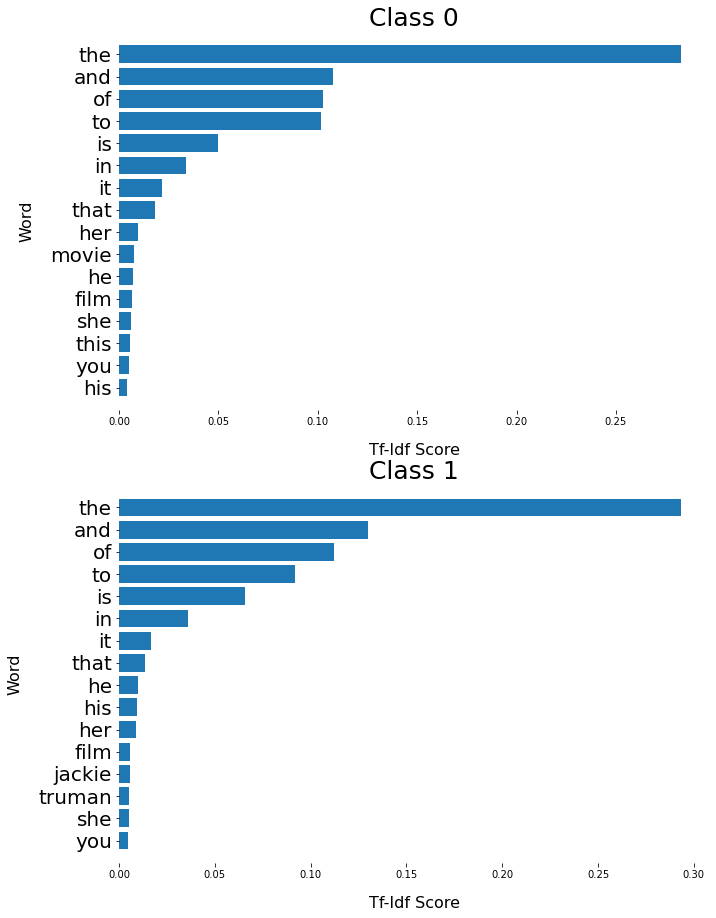

In [231]:

class_features = vectorizer.get_feature_names()
class_top_dfs = top_feats_by_class(x, y, class_features)
plot_tfidf_classfeats_h(class_top_dfs, 7)

In [107]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=20):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=10):
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=16):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs, num_class=9):
    fig = plt.figure(figsize=(10, 50), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(num_class, 1, i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=16)
        ax.set_ylabel("Word", labelpad=16, fontsize=16)
        ax.set_title('Class '+str(df.label) , fontsize=25)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        ax.invert_yaxis()
        yticks = ax.set_yticklabels(df.feature)
        
        for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(20) 
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [232]:
from sklearn.model_selection import train_test_split 
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)


In [233]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB, CategoricalNB
naive_bayes_tfidf = GaussianNB()
naive_bayes_tfidf.fit(x_train.toarray(), y_train)
#making predictions
y_pred = naive_bayes_tfidf.predict(x_test.toarray())
#model accuracy
print("Model Accuracy : {}%".format((y_pred == y_test).mean()*100))
#confusion matrix 
from sklearn.metrics import confusion_matrix 
print(confusion_matrix(y_test,y_pred))

Model Accuracy : 65.0%
[[123  76]
 [ 64 137]]


### BOW

In [193]:
from sklearn.feature_extraction.text import CountVectorizer
bof_vec = CountVectorizer(stop_words='english')#, max_features=1000)
x_bow = bof_vec.fit_transform(df['text']) 
y_bow =  df['class']

In [194]:
x_train2,x_test2,y_train2,y_test2 = train_test_split(x_bow,y_bow,test_size=0.2)

In [ ]:
y_test2

In [195]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes_bow = MultinomialNB()
naive_bayes_bow.fit(x_train2, y_train2)
#making predictions
y_pred2 = naive_bayes_bow.predict(x_test2)
#model accuracy
print("Model Accuracy : {}%".format((y_pred2 == y_test2).mean()*100))
#confusion matrix 
from sklearn.metrics import confusion_matrix 
print(confusion_matrix(y_test2,y_pred2))

Model Accuracy : 82.0%
[[163  37]
 [ 35 165]]


In [ ]:
from sklearn.linear_model import LinearRegression

clf = LogisticRegression(random_state=0, solver='lbfgs')
clf.fit(x_train, y_train)
#making predictions
y_pred = clf.predict(x_test)
#model accuracy
print("Model Accuracy : {}%".format((y_pred == y_test).mean()*100))
#confusion matrix 
from sklearn.metrics import confusion_matrix 
print(confusion_matrix(y_test,y_pred))